In [8]:
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [9]:
crypto_symbol = 'BTC-USD'
data = yf.download(crypto_symbol, start='2021-01-01', end='2024-01-01')

# Używamy tylko ceny zamknięcia
btc_prices = data['Close'].dropna()

[*********************100%***********************]  1 of 1 completed


In [12]:
def lppl(t, A, B, C, tc, m, omega, phi):
    # Zabezpieczenie przed nieprawidłowymi wartościami t_c - t
    valid = (tc - t) > 0
    result = np.zeros_like(t, dtype=float)
    result[valid] = A + B * np.power(tc - t[valid], m) + C * np.power(tc - t[valid], m) * np.cos(omega * np.log(tc - t[valid]) + phi)
    return result

In [18]:
t = np.arange(0, len(btc_prices))
p = np.log(btc_prices.values)

# Dopasowanie parametrów do modelu LPPL
initial_guess = [10, -1, 1, len(btc_prices) + 90, 0.4, 10, 0]  # Zwiększ tc, zmień omega i m

bounds = ([0, -np.inf, -np.inf, len(btc_prices), 0, 0, -np.pi], [np.inf, 0, np.inf, len(btc_prices) + 200, 1, 20, np.pi])
params, _ = curve_fit(lppl, t, p, p0=initial_guess, bounds=bounds, maxfev=10000)


In [19]:
t_future = np.arange(0, len(btc_prices) + 100)
predicted_prices = np.exp(lppl(t_future, *params))

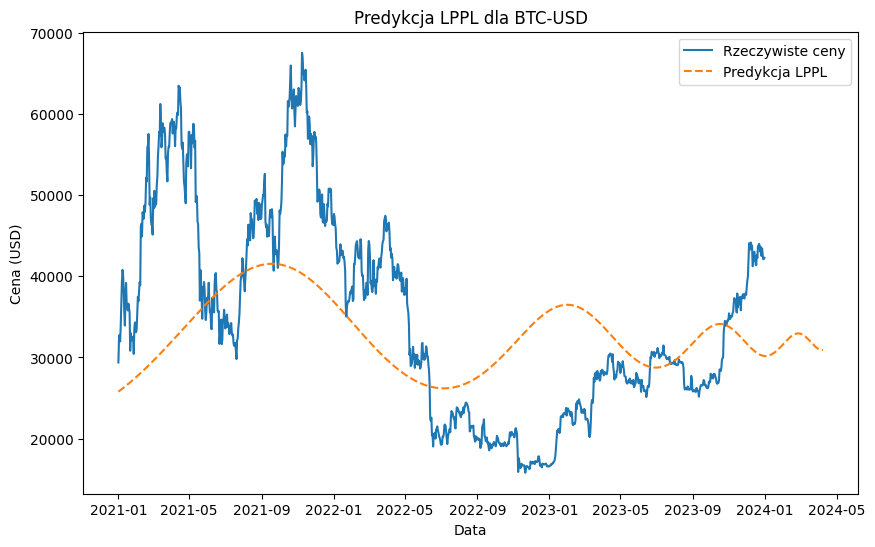

Dopasowane parametry modelu LPPL:
A: 10.366095189945375, B: -3.583872542194802e-37, C: 0.00026084729101769045, tc: 1294.9999999999998, m: 0.9999999999409449, omega: 9.518388213045274, phi: 3.1415926535897927


In [20]:
plt.figure(figsize=(10, 6))
plt.plot(btc_prices.index, btc_prices, label='Rzeczywiste ceny')
plt.plot(btc_prices.index.append(pd.date_range(btc_prices.index[-1], periods=100, freq='D')),
         predicted_prices, label='Predykcja LPPL', linestyle='--')
plt.title(f'Predykcja LPPL dla {crypto_symbol}')
plt.xlabel('Data')
plt.ylabel('Cena (USD)')
plt.legend()
plt.show()

print("Dopasowane parametry modelu LPPL:")
print(f"A: {params[0]}, B: {params[1]}, C: {params[2]}, tc: {params[3]}, m: {params[4]}, omega: {params[5]}, phi: {params[6]}")